In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../../')

from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
# from RF_Utils import *
from RF_GSCV import *



# Load inhibition data 

In [2]:

split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib'
train_x_df = pd.read_csv(split_path+"/inhib_train_x_Morgan2SMOTE.csv")
train_y_df= pd.read_csv(split_path+"/inhib_train_y_Morgan2SMOTE.csv")
test_x_df= pd.read_csv(split_path+"/inhib_test_x_Morgan2SMOTE.csv")
test_y_df= pd.read_csv(split_path+"/inhib_test_y_Morgan2SMOTE.csv")

train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((3045, 2048), (3045,), (408, 2048), (408,))

# SMOTE

TRAIN: accuracy: 0.999, precision: 0.999, recall: 0.999, specificity: 0.999
TEST: accuracy: 0.944, precision: 0.593, recall: 0.571, specificity: 0.971


<Figure size 600x400 with 0 Axes>

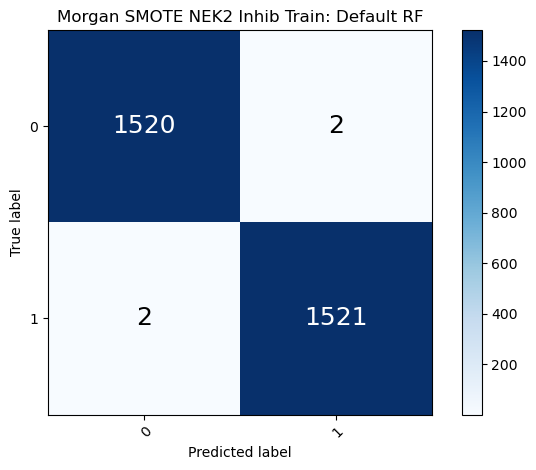

<Figure size 600x400 with 0 Axes>

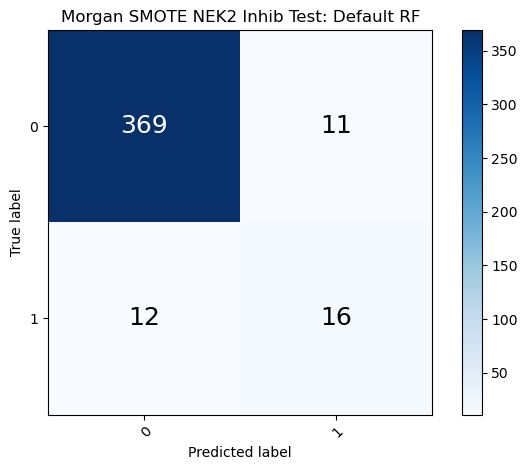

In [3]:
rf_basic100estSMOTE = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {})
plot_confusion_matrix(train_y, rf_basic100estSMOTE['train_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100estSMOTE['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Test: Default RF')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [6]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [4]:
save_file = 'atom_nek2inhibMorgan2SMOTE_rf_basic_best.pkl'
# rf_basicbestSMOTE = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  2)
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbestSMOTE['best_model'], f)

TRAIN: accuracy: 0.991, precision: 0.997, recall: 0.986,  specificity: 0.997
TEST: accuracy: 0.939, precision: 0.560, recall: 0.500, specificity: 0.971


<Figure size 600x400 with 0 Axes>

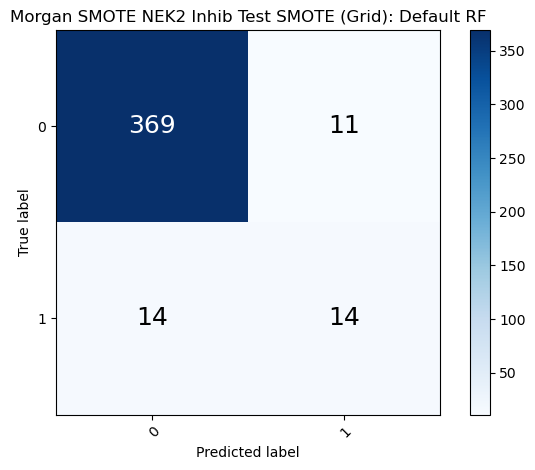

In [5]:
with open('../saved_models/'+save_file, 'rb') as f: 
    rf_basicbestSMOTE = pickle.load(f) 
best_basic_results = rf_results2(rf_basicbestSMOTE, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, best_basic_results['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Test SMOTE (Grid): Default RF')



# Basic RF + classweight balanced 

TRAIN: accuracy: 0.999, precision: 0.999, recall: 0.999, specificity: 0.999
TEST: accuracy: 0.939, precision: 0.556, recall: 0.536, specificity: 0.968


<Figure size 600x400 with 0 Axes>

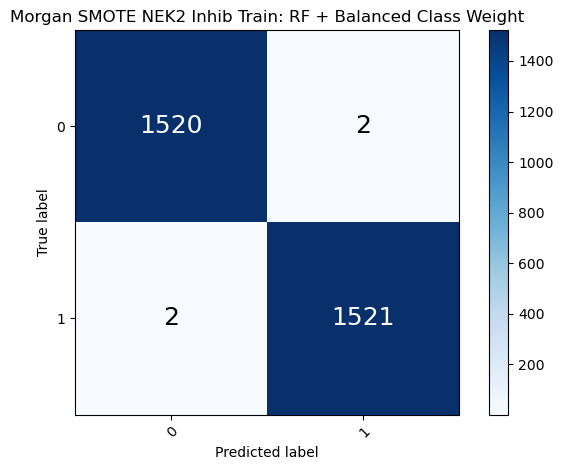

<Figure size 600x400 with 0 Axes>

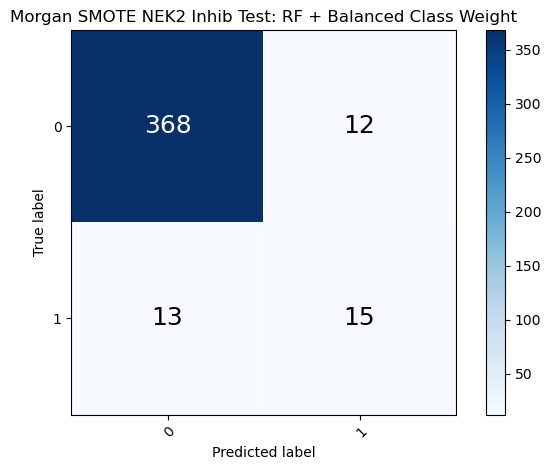

In [6]:
brf_model_BCW_SMOTE = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {})
plot_confusion_matrix(train_y, brf_model_BCW_SMOTE['train_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW_SMOTE['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Test: RF + Balanced Class Weight')

In [8]:
save_file2 = 'atom_nek2inhibMorgan2SMOTE_rf_basicBCW_best.pkl'
# rf_basicBCWbestSMOTE = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  2)
# started Apr 28 2:32 am 


In [9]:
save_file2 = 'atom_nek2inhibMorgan2SMOTE_rf_basicBCW_best.pkl'
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbestSMOTE['best_model'], f)


TRAIN: accuracy: 0.547, precision: 0.847, recall: 0.116,  specificity: 0.979
TEST: accuracy: 0.912, precision: 0.167, recall: 0.071, specificity: 0.974


<Figure size 600x400 with 0 Axes>

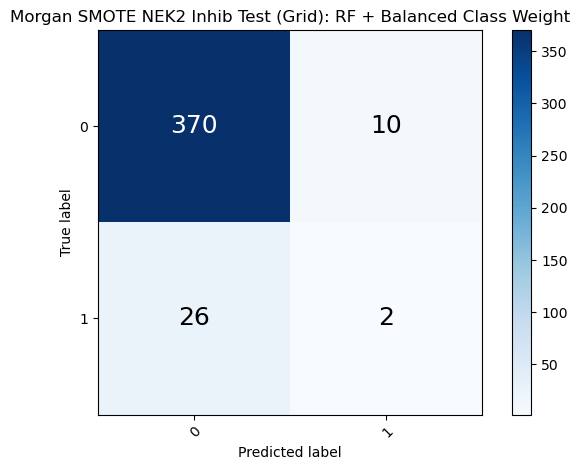

In [10]:
with open('../saved_models/'+save_file2, 'rb') as f: 
    rf_basicBCWbestSMOTE = pickle.load(f) 
rf_basicBCWbestSMOTE_results = rf_results2(rf_basicBCWbestSMOTE, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, rf_basicBCWbestSMOTE_results['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Test (Grid): RF + Balanced Class Weight')



# Balanced Random Forest Classifier

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.999, precision: 0.999, recall: 0.999, specificity: 0.999
TEST: accuracy: 0.953, precision: 0.667, recall: 0.643, specificity: 0.976


<Figure size 600x400 with 0 Axes>

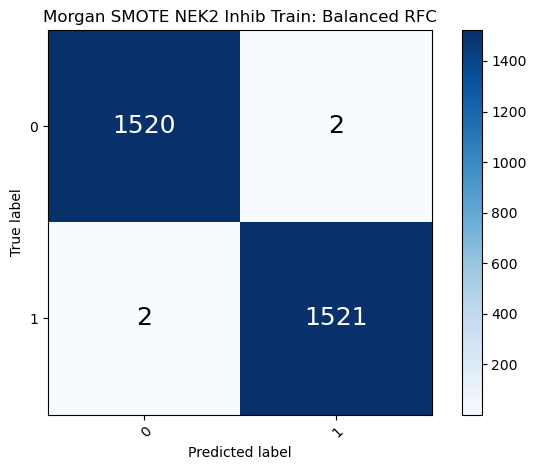

<Figure size 600x400 with 0 Axes>

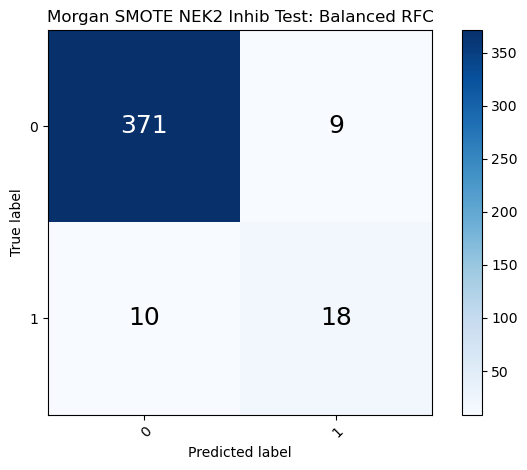

In [11]:
brf_modelSMOTE = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {})
plot_confusion_matrix(train_y, brf_modelSMOTE['train_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_modelSMOTE['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Test: Balanced RFC')

In [12]:
save_file3 = 'atom_nek2inhibMorgan2SMOTE_BRFC_best.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, param_grid,2)
# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_best['best_model'], f)


TRAIN: accuracy: 0.991, precision: 0.997, recall: 0.986,  specificity: 0.997
TEST: accuracy: 0.941, precision: 0.583, recall: 0.500, specificity: 0.974


<Figure size 600x400 with 0 Axes>

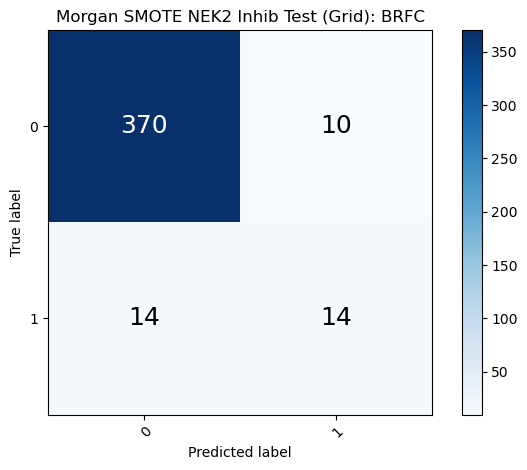

In [13]:
save_file3 = 'atom_nek2inhibMorgan2SMOTE_BRFC_best.pkl'
with open('../saved_models/'+save_file3, 'rb') as f: 
    brfc_best = pickle.load(f) 
brfc_best_results = rf_results2(brfc_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, brfc_best_results['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Test (Grid): BRFC')



# Try BRFC with balanced class weight & bootstrap

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.999, precision: 0.997, recall: 1.000, specificity: 0.997
TEST: accuracy: 0.953, precision: 0.680, recall: 0.607, specificity: 0.979


<Figure size 600x400 with 0 Axes>

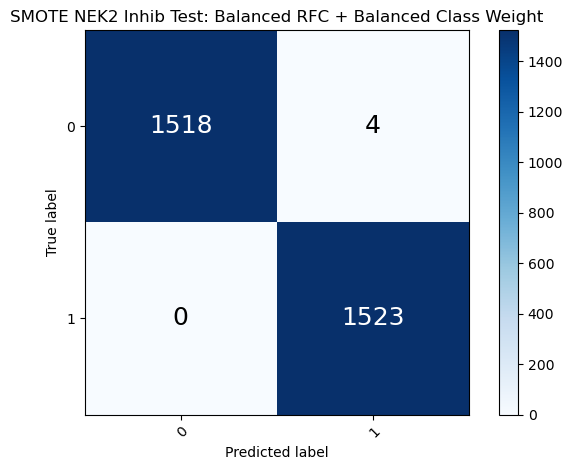

<Figure size 600x400 with 0 Axes>

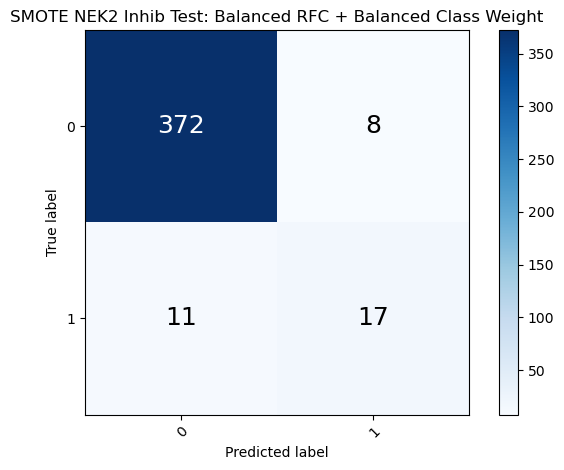

In [14]:
brf_modelCWB_SMOTE = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True})
plot_confusion_matrix(train_y, brf_modelCWB_SMOTE['train_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB_SMOTE['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')

In [15]:
save_file4 = 'atom_nek2inhibMorgan2SMOTE_BRFC_BCW_best.pkl'
# brfc_BCW_SMOTE_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True},2)


TRAIN: accuracy: 0.993, precision: 0.993, recall: 0.994,  specificity: 0.993
TEST: accuracy: 0.963, precision: 0.760, recall: 0.679, specificity: 0.984


<Figure size 600x400 with 0 Axes>

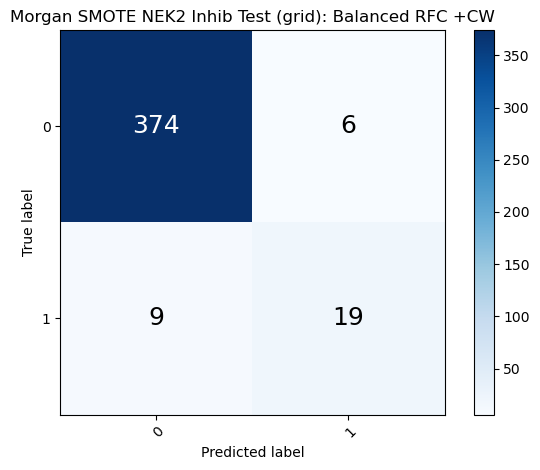

In [16]:
save_file4 = 'atom_nek2inhibMorgan2SMOTE_BRFC_BCW_best.pkl'
# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_SMOTE_best['best_model'], f)
with open('../saved_models/'+save_file4, 'rb') as f: 
    brfc_BCW_SMOTEbest = pickle.load(f) 
brfc_BCW_SMOTEbestresults = rf_results2(brfc_BCW_SMOTEbest, train_x, train_y, test_x, test_y)

plot_confusion_matrix(test_y, brfc_BCW_SMOTEbestresults['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Inhib Test (grid): Balanced RFC +CW')



In [ ]:
brfc_BCW_SMOTE_best['best_model']

In [55]:
nek2inhib_SMOTEmodels = {'default_RF':rf_basicbestSMOTE, 'rf_bcw':rf_basicBCWbestSMOTE,
                              'BRFC':brfc_best, 'BRFC_bcw':brfc_BCW_SMOTE_best['best_model']}

with open('nek2inhib_Morgan2SMOTEmodels.pkl', 'wb') as f:
    pickle.dump(nek2inhib_SMOTEmodels, f)


In [56]:
grid_models = [rf_basicbestSMOTE, rf_basicBCWbestSMOTE,brfc_best,brfc_BCW_SMOTE_best['best_model']]
model_dictionaries = []
for i, model in enumerate(grid_models): 
    print(type(model))
    train_results = save_rf_results(model, train_x, train_y)
    test_results  = save_rf_results(model, test_x, test_y) 
    model_dict = {'model':model, 'train_results':train_results, 'test_results':test_results}
    model_dictionaries.append(model_dict) 

with open('nek2_inhib_Morgan2SMOTE_results.pkl', 'wb') as f:
    pickle.dump(model_dictionaries, f)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'>
<class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'>


In [57]:
with open('nek2_inhib_Morgan2SMOTE_results.pkl', 'rb') as f: 
    results1= pickle.load(f)
recalls = [] 
for m, model in enumerate(results1): 
    recalls.append(model['test_results']['recall'])
# recalls

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 86.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 87.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


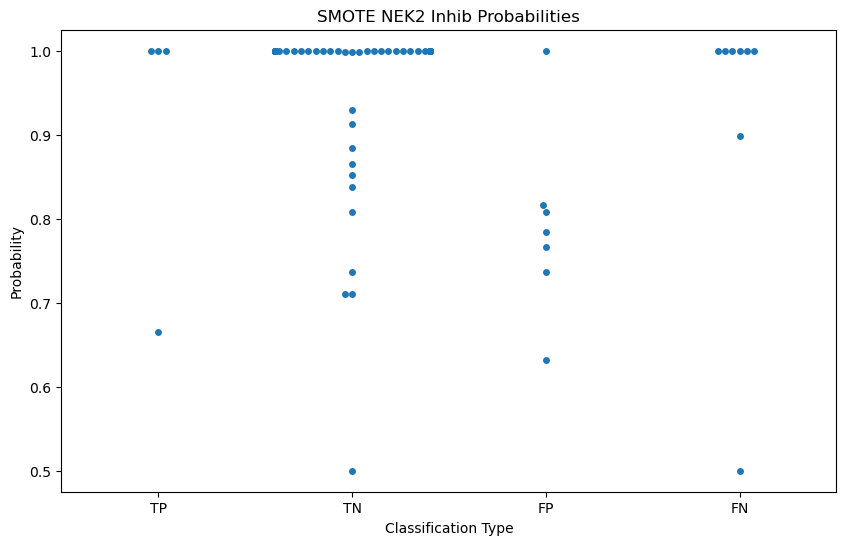

In [60]:
swarm_prob(brfc_BCW_SMOTE_best['best_model'], test_x, test_y, 'SMOTE NEK2 Inhib Probabilities')